In [34]:
import datetime
import pandas as pd
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import random
from operator import itemgetter
import time
import copy
import seaborn as sns
random.seed(2)




In [35]:
from matplotlib import pyplot as plt

In [36]:
%matplotlib inline

In [37]:
print(plt.style.available)

['seaborn-muted', 'seaborn-poster', 'fivethirtyeight', 'seaborn-white', 'seaborn-darkgrid', 'seaborn-paper', 'seaborn-dark', 'seaborn-whitegrid', 'seaborn-notebook', 'seaborn-colorblind', 'classic', 'seaborn-dark-palette', 'seaborn-bright', 'grayscale', 'seaborn-pastel', 'seaborn-ticks', 'bmh', 'ggplot', 'seaborn-talk', 'seaborn-deep', 'dark_background']


In [38]:
plt.style.use('seaborn-talk')

(-1, 9)

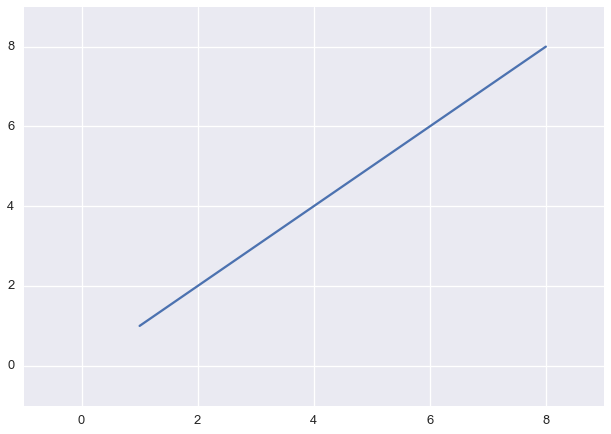

In [39]:
x = np.linspace(1,8)
y = x
plt.plot(x,y)
plt.xlim(-1,9)
plt.ylim(-1,9)

# Load train data 

In [40]:
df_train = pd.read_csv('train.csv')

In [41]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#  this is the way to normalize the label distribution, but I did not use it

In [42]:
#df_train.SalePrice = np.log1p(df_train.SalePrice)

#  lorad test data

In [43]:
df_test = pd.read_csv('test.csv')

# concate train and test to one dataframe to make dammy columns

In [44]:
df_test['SalePrice'] = -1

In [45]:
df = pd.concat([df_train, df_test])

In [46]:
df = df.drop('Id', axis = 1)

In [47]:
s = df.dtypes

In [48]:
object_columns= s[s.values == 'object'].index.values

In [49]:
for item in object_columns:
    df[item] = df[item].astype('category')

In [50]:
df = pd.get_dummies(df)

#  Dealing with missing values

In [51]:
columns = df.columns.values

In [52]:
null_columns =[]
for item in columns:
    print(item, df[item].isnull().any().sum())
    if df[item].isnull().any().sum() == 1:
        null_columns.append(item)

MSSubClass 0
LotFrontage 1
LotArea 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
MasVnrArea 1
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 1
BsmtHalfBath 1
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
TotRmsAbvGrd 0
Fireplaces 0
GarageYrBlt 1
GarageCars 1
GarageArea 1
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
MiscVal 0
MoSold 0
YrSold 0
SalePrice 0
MSZoning_C (all) 0
MSZoning_FV 0
MSZoning_RH 0
MSZoning_RL 0
MSZoning_RM 0
Street_Grvl 0
Street_Pave 0
Alley_Grvl 0
Alley_Pave 0
LotShape_IR1 0
LotShape_IR2 0
LotShape_IR3 0
LotShape_Reg 0
LandContour_Bnk 0
LandContour_HLS 0
LandContour_Low 0
LandContour_Lvl 0
Utilities_AllPub 0
Utilities_NoSeWa 0
LotConfig_Corner 0
LotConfig_CulDSac 0
LotConfig_FR2 0
LotConfig_FR3 0
LotConfig_Inside 0
LandSlope_Gtl 0
LandSlope_Mod 0
LandSlope_Sev 0
Neighborhood_Blmngtn 0
Neighborhood_Blueste 0
Neighborhood_BrDale 0
Neighborhood_BrkSid

In [53]:
columns_to_fill_zero = []
for item in null_columns:
    print(item, (df[item].isnull().sum().sum()/len(df)*100), "%" )
    if df[item].isnull().sum().sum()/len(df)*100 >5:
        columns_to_fill_zero.append(item)

LotFrontage 16.6495375128 %
MasVnrArea 0.787941075711 %
BsmtFinSF1 0.0342583076396 %
BsmtFinSF2 0.0342583076396 %
BsmtUnfSF 0.0342583076396 %
TotalBsmtSF 0.0342583076396 %
BsmtFullBath 0.0685166152792 %
BsmtHalfBath 0.0685166152792 %
GarageYrBlt 5.4470709147 %
GarageCars 0.0342583076396 %
GarageArea 0.0342583076396 %


## columns having >5% missing values, fill 0 to there

In [54]:
columns_to_fill_zero

['LotFrontage', 'GarageYrBlt']

In [55]:
for item in columns_to_fill_zero:
    print(item)
    df[item]= df[item].fillna(0)

LotFrontage
GarageYrBlt


# columns having <5% missing values, fill with mean values

In [56]:

df = df.fillna(df.mean())

#  split train and test again

In [57]:
train = df[df.SalePrice >0]

In [58]:
test = df[df.SalePrice == -1]

In [59]:
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [60]:
test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [61]:
y_train = train.SalePrice

In [62]:
y_test = test.SalePrice

In [63]:
x_train = train.drop("SalePrice", axis =1)

In [64]:
x_test = test.drop("SalePrice", axis =1)

In [65]:
y_train = y_train.values

In [66]:
y_test = y_test.values

In [67]:
x_train = x_train.values

In [68]:
x_test = x_test.values

# define evaluation method

In [69]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())




#  split train sample for internal testing

In [70]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [71]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x_train,y_train, random_state=0)

#  prediction

#  random forest

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
reg = RandomForestRegressor(n_estimators=100)

In [74]:
reg.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [75]:
prediction = reg.predict(Xtest)

In [76]:
rmse(prediction, ytest)

30909.126956536798

30909.1269565


(-1, 9)

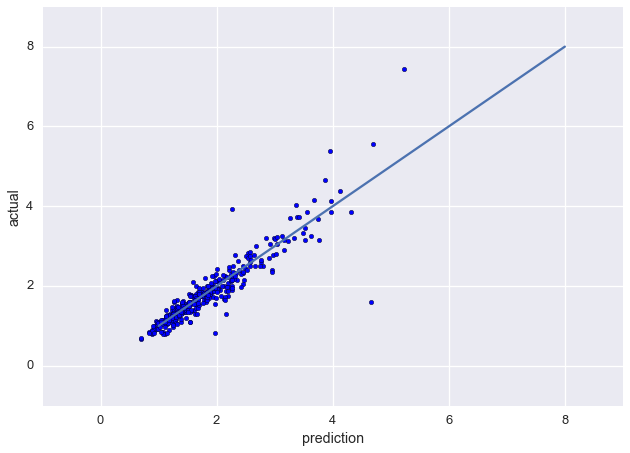

In [78]:
print(rmse(prediction, ytest))
plt.scatter((prediction)/100000, (ytest)/100000)
plt.xlabel('prediction')
plt.ylabel('actual')

plt.plot(x,y)
plt.xlim(-1,9)
plt.ylim(-1,9)

#  change data format for xgboost

In [79]:
import xgboost as xgb

In [80]:
random_state = 0

In [81]:
dtrain = xgb.DMatrix(Xtrain, ytrain)
dvalid = xgb.DMatrix(Xtest, ytest)

dtest = xgb.DMatrix(x_test, y_test)
d_all_train = xgb.DMatrix(x_train, y_train)

#  thus far this is the best one  -XGBoost

In [89]:
num_boost_round = 50000

In [90]:
eta = 0.01
max_depth = 7
subsample = 0.4
colsample_bytree = 0.4
start_time = time.time()

print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
params = {
        "objective": "reg:linear",
        "booster" : "gbtree",
        "eval_metric": "rmse",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": 0
}

early_stopping_rounds = 15




XGBoost params. ETA: 0.01, MAX_DEPTH: 7, SUBSAMPLE: 0.4, COLSAMPLE_BY_TREE: 0.4


In [91]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)




Will train until eval error hasn't decreased in 15 rounds.
[0]	train-rmse:195331.593750	eval-rmse:196946.953125
[1]	train-rmse:193538.531250	eval-rmse:195163.281250
[2]	train-rmse:191775.671875	eval-rmse:193402.125000
[3]	train-rmse:189980.531250	eval-rmse:191644.921875
[4]	train-rmse:188245.562500	eval-rmse:189887.078125
[5]	train-rmse:186518.531250	eval-rmse:188167.515625
[6]	train-rmse:184783.656250	eval-rmse:186419.000000
[7]	train-rmse:183138.656250	eval-rmse:184802.375000
[8]	train-rmse:181415.187500	eval-rmse:183058.156250
[9]	train-rmse:179714.343750	eval-rmse:181366.859375
[10]	train-rmse:178083.265625	eval-rmse:179717.406250
[11]	train-rmse:176508.828125	eval-rmse:178127.546875
[12]	train-rmse:174876.906250	eval-rmse:176527.031250
[13]	train-rmse:173262.687500	eval-rmse:174953.187500
[14]	train-rmse:171686.953125	eval-rmse:173358.203125
[15]	train-rmse:170173.328125	eval-rmse:171843.328125
[16]	train-rmse:168595.890625	eval-rmse:170242.812500
[17]	train-rmse:167041.953125	eva

25365.5114489


(-1, 9)

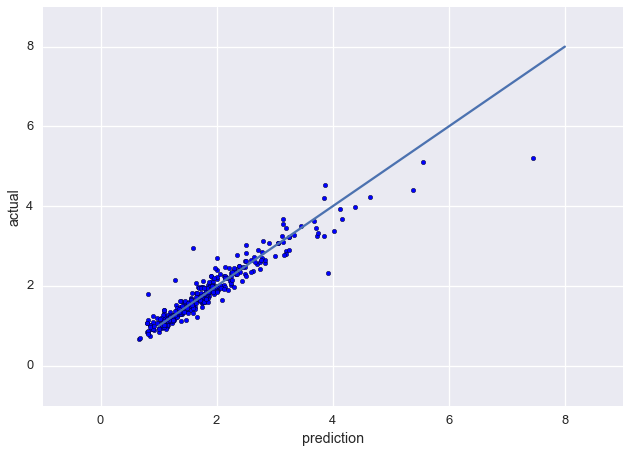

In [92]:
ypred = gbm.predict(dvalid)
print(rmse(ytest, ypred))
plt.scatter((ytest)/100000, (ypred)/100000)
plt.xlabel('prediction')
plt.ylabel('actual')

plt.plot(x,y)
plt.xlim(-1,9)
plt.ylim(-1,9)

#  modify from the best -3  === This is the best for today's attempts!

In [93]:
eta = 0.005
max_depth = 8
subsample = 0.5
colsample_bytree = 0.5
start_time = time.time()

print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
params = {
        "objective": "reg:linear",
        "booster" : "gbtree",
        "eval_metric": "rmse",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": 0
}

early_stopping_rounds = 25



XGBoost params. ETA: 0.005, MAX_DEPTH: 8, SUBSAMPLE: 0.5, COLSAMPLE_BY_TREE: 0.5


In [94]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)





Will train until eval error hasn't decreased in 25 rounds.
[0]	train-rmse:196239.234375	eval-rmse:197896.109375
[1]	train-rmse:195307.578125	eval-rmse:196976.484375
[2]	train-rmse:194415.468750	eval-rmse:196080.718750
[3]	train-rmse:193496.343750	eval-rmse:195178.015625
[4]	train-rmse:192614.234375	eval-rmse:194298.281250
[5]	train-rmse:191721.359375	eval-rmse:193418.984375
[6]	train-rmse:190811.421875	eval-rmse:192496.046875
[7]	train-rmse:189940.640625	eval-rmse:191632.828125
[8]	train-rmse:189046.609375	eval-rmse:190733.750000
[9]	train-rmse:188166.593750	eval-rmse:189852.734375
[10]	train-rmse:187304.562500	eval-rmse:188976.484375
[11]	train-rmse:186421.312500	eval-rmse:188123.218750
[12]	train-rmse:185558.984375	eval-rmse:187287.562500
[13]	train-rmse:184702.875000	eval-rmse:186447.796875
[14]	train-rmse:183853.328125	eval-rmse:185600.765625
[15]	train-rmse:182999.796875	eval-rmse:184757.859375
[16]	train-rmse:182137.500000	eval-rmse:183874.593750
[17]	train-rmse:181297.906250	eva

25003.2696528


(-1, 9)

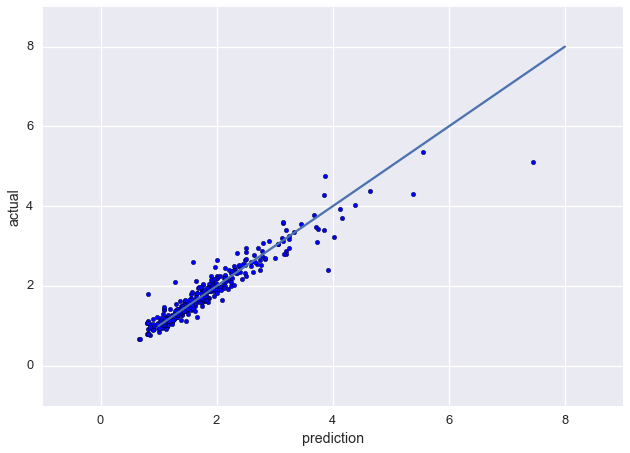

In [95]:
ypred = gbm.predict(dvalid)
print(rmse(ytest, ypred))

plt.scatter((ytest)/100000, (ypred)/100000)
plt.xlabel('prediction')
plt.ylabel('actual')

plt.plot(x,y)
plt.xlim(-1,9)
plt.ylim(-1,9)


#  make final prediction with all data 

In [96]:
prediction = gbm.predict(dtest)

In [97]:
prediction

array([ 125326.078125,  163376.921875,  187525.421875, ...,  165437.859375,
        110804.15625 ,  225171.6875  ], dtype=float32)

In [98]:
df_submission = pd.read_csv('sample_submission.csv')

In [99]:
df_submission.SalePrice = prediction

In [100]:
df_submission.to_csv('xgboost_alltrain_meetup.csv', index = False)